In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt
import cv2
#! pip install albumentations==0.4.6

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [2]:
# Hyperparameters
n_epochs = 10
learning_rate = 1e-03
batch_size = 8
image_height = 224
image_width = 224
SMOOTH = 1e-6

In [3]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

class VOCDataset(Dataset):
    """
    This class is for the creation of VOC2012 dataset
    """

    def __init__(self, root_path='VOC2012/',
                 type = 'train', image_size=(224, 224), resize_method='resize',transform = None):
        self.root_path = root_path
        self.resize_method = resize_method
        self.type = type
        self.transform = transform

        # define directory where train and val pictures names are stored
        self.names_path = self.root_path + 'ImageSets/Segmentation/'+ self.type +'.txt'

        # define image and labels path
        self.image_path = self.root_path + 'JPEGImages/'
        self.label_path = self.root_path + 'SegmentationClass/'
        self.image_size = image_size

        # define array of picture names, images and labels
        self.names = []
        self.images = []
        self.labels = []

        # parms for converting label pixels to class pixels
        self.colormap2label = self.build_colormap2label()
        self.mode = torchvision.io.image.ImageReadMode.RGB

        # reading file names
        self.read_names()

    def __getitem__(self, index):

        image = cv2.imread(self.image_path + self.names[index] + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.label_path + self.names[index] + '.png')
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=label)
            image = augmentations["image"]
            label = augmentations["mask"]

        label = self.voc_label_indices(label, self.colormap2label)

        return image.to(device), label.to(device)

    def __len__(self):
        return len(self.names)

    def read_names(self):
        """
        Read the filenames of training images and labels into self.names
        """
        f = open(self.names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n','')
            if line is None or len(line) == 0 :
                break
            self.names.append(line)
        f.close()
    def build_colormap2label(self):
        """
        Build an RGB color to label mapping for segmentation.
        """
        colormap2label = torch.zeros(256**3, dtype=torch.long)
        for i, colormap in enumerate(VOC_COLORMAP):
            colormap2label[(colormap[0] * 256 + colormap[1]) * 256 +
                colormap[2]] = i
        return colormap2label


    def voc_label_indices(self,colormap, colormap2label):
        """
        Map an RGB color to a label.
        """
        #colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
        colormap = colormap.numpy().astype('int32')
        idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 +
            colormap[:, :, 2])
        return colormap2label[idx]

# Define the helper function which transfers label to RGB picture
def decode_segmap(image, nc=21):
  label_colors = np.array(VOC_COLORMAP)

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [4]:
class DoubleConv(nn.Module):
    """
    This class is for creating double layer of Conv
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    """
    This class is UNET class where we define the entire architecture
    """

    # we are declaring features in advance because we already know that from
    # UNET Architecture
    def __init__(self, in_channels=3, out_channels=20, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()

        # list of downsampling
        self.downs = nn.ModuleList()

        # bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # max pool
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # list of upsampling
        self.ups = nn.ModuleList()

        # final layer of conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        # down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))


    def forward(self, x):
        # we will store skipped connections to concatenate later
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        # we will reverse list of skip connections
        skip_connections = skip_connections[::-1]
        # our step for loop is 2 because one step of upsampling uses two Modules:
        # ConvTranspose2d and DoubleConv
        for idx in range(0, len(self.ups), 2):

            # upsampling
            x = self.ups[idx](x)
            # get skipped connection for concatenation
            skip_connection = skip_connections[idx//2]

            # if our input shape is not dividible by 16, we may have some
            # errors regarding the shape. To preven those errors we will reshape
            # our x in case of difference of shapes. We are doing that because
            # torch.cat() needs two same dimensional Tensors to concatenate.
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # concatenation part
            concat_skip = torch.cat((skip_connection, x), dim=1)
            # DoubleConv layer
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

In [5]:
# Define transformers
# use mean=[0.485, 0.456, 0.406] and variance std=[0.229, 0.224, 0.225] for normalization.
train_transform = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            A.Rotate(limit=35, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
val_transform = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            ToTensorV2()
        ],
)

# get datasets
train_dataset = VOCDataset(image_size=(image_height, image_width),
                           type='train', transform=train_transform)

val_dataset = VOCDataset(image_size=(image_height, image_width),
                         type='val', transform=val_transform)

In [6]:
def check_accuracy(data_loader, model):
    model.eval()
    """
    This function is for checking accuracy using IoU
    """
    with torch.no_grad():
        for x,y in data_loader:
            pred = model(x)
            print(f"IoU is {IoU(pred,y):.2f}")

    model.train()

In [7]:
def train(n_epochs, data_loader, model, optimizer, loss_fn):
    """
    this function is for training model. one epoch is one call of this function
    """
    print('training start')
    history = {'loss': []}
    for epoch in range(n_epochs):
        for i, (image,target) in enumerate(data_loader):
            # forward propagation
            predictions = model(image)
            loss = loss_fn(predictions, target)
            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i%25 ==0:
                print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss}')
            history['loss'].append(loss)
        #check_accuracy(val_loader, model)
    return history

In [8]:
# create DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# define loss, model and optimizer
loss_fn = nn.CrossEntropyLoss()
model = UNET(in_channels = 3, out_channels = 21).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# print model
print(model)

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [9]:
# call train
history = train(n_epochs, train_loader,model,optimizer,loss_fn)

training start
Epoch: 0, Iteration: 0, Loss: 3.085481643676758
Epoch: 0, Iteration: 25, Loss: 2.064877510070801
Epoch: 0, Iteration: 50, Loss: 1.2255311012268066
Epoch: 0, Iteration: 75, Loss: 1.1940670013427734
Epoch: 0, Iteration: 100, Loss: 1.0275946855545044
Epoch: 0, Iteration: 125, Loss: 1.3253693580627441
Epoch: 0, Iteration: 150, Loss: 1.4661426544189453
Epoch: 0, Iteration: 175, Loss: 0.8659782409667969
Epoch: 1, Iteration: 0, Loss: 1.1215976476669312
Epoch: 1, Iteration: 25, Loss: 1.0948761701583862
Epoch: 1, Iteration: 50, Loss: 0.7504437565803528
Epoch: 1, Iteration: 75, Loss: 1.3874908685684204
Epoch: 1, Iteration: 100, Loss: 1.3522287607192993
Epoch: 1, Iteration: 125, Loss: 1.1835180521011353
Epoch: 1, Iteration: 150, Loss: 1.4019614458084106
Epoch: 1, Iteration: 175, Loss: 1.3952178955078125
Epoch: 2, Iteration: 0, Loss: 1.344679832458496
Epoch: 2, Iteration: 25, Loss: 1.2314530611038208
Epoch: 2, Iteration: 50, Loss: 1.282959222793579
Epoch: 2, Iteration: 75, Loss: 1.2

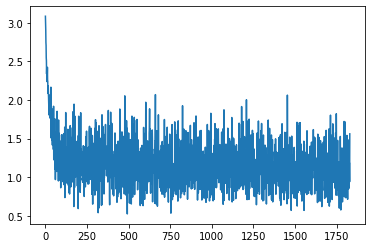

In [26]:
# plot loss progression
hist = []
for loss in history['loss']:
    hist.append(loss.detach().cpu())
plt.plot(hist)

In [27]:
# save model
torch.save(model, 'modelV1.pt')

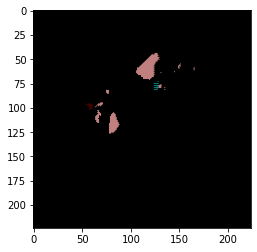

In [34]:
# make prediction
img, label = val_dataset[50]
pred = model(img.unsqueeze(0).float())

# softmax and torch.max
pred = F.softmax(pred, dim=1)
values, prediction = torch.max(pred, dim=1)

# decode and plot prediction
rgb = decode_segmap(prediction.detach().cpu().squeeze(0))
plt.imshow(rgb); plt.show()

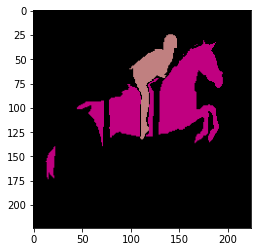

In [36]:
label = decode_segmap(label.detach().cpu())
plt.imshow(label)